# Testing

This is a notebook to test CA3 v different CCA methods.

## Imports

In [1]:
import numpy as np
from sklearn.cross_decomposition import CCA
from ca3 import CA3
from gemmr.generative_model import GEMMR

## Generate data

This generates two matricies with a known canoncial correaltion of around 0.3

## Example way to do it
#### Parameters
n_samples = 200
dim_x = 50
dim_y = 5
latent_dim = 1
desired_corr = 0.3
rng = np.random.default_rng(42)

##### Step 1: Latent Z with identity covariance
Z = rng.standard_normal((n_samples, latent_dim))

##### Step 2: Random orthonormal projection matrices
def random_proj(input_dim, output_dim):
    A = rng.standard_normal((input_dim, output_dim))
    Q, _ = np.linalg.qr(A)
    return Q

A = random_proj(latent_dim, dim_x)
B = random_proj(latent_dim, dim_y)

#### Step 3: Construct true canonical variables with exact corr = 0.3
#### Generate X = Z * A.T
#### Generate Y = (desired_corr * Z + sqrt(1 - r^2) * noise) * B.T
X_signal = Z @ A.T
Y_latent = desired_corr * Z + np.sqrt(1 - desired_corr**2) * rng.standard_normal((n_samples, latent_dim))
Y_signal = Y_latent @ B.T

##### (Optional) add independent noise to X and Y
X = X_signal  # + noise if you want
Y = Y_signal

In [3]:
model_definition = GEMMR('cca', wx=1, wy=1, r_between=0.3)
behavioural_data_study1, imging_data_study1 = model_definition.generate_data(n=200)
behavioural_data_study2, imging_data_study2 = model_definition.generate_data(n=190)
study1 = (imging_data_study1, behavioural_data_study1) 
study2 = (imging_data_study2, behavioural_data_study2)

## Sckit learn

In [23]:
cca = CCA(n_components=1)
X1_proj_cca, Y1_proj_cca = cca.fit_transform(behavioural_data_study1, imging_data_study1)
sklearn_corr = np.corrcoef(X1_proj_cca.T, Y1_proj_cca.T)[0, 1]
print(f"Empirical canonical correlation: {sklearn_corr:.3f}")

Empirical canonical correlation: 0.334


## Mine

In [ ]:
ca3_model = CA3(l2=0)
projections = ca3_model.fit_transform(study1)
ca3_corr = ca3_model.calculate_canonical_correlations()[0]
print(f"{ca3_corr:.3f}")

0.334


TtestResult(statistic=np.float64(1.3322676295501883e-16), pvalue=np.float64(0.9999999999999999), df=np.float64(398.0))

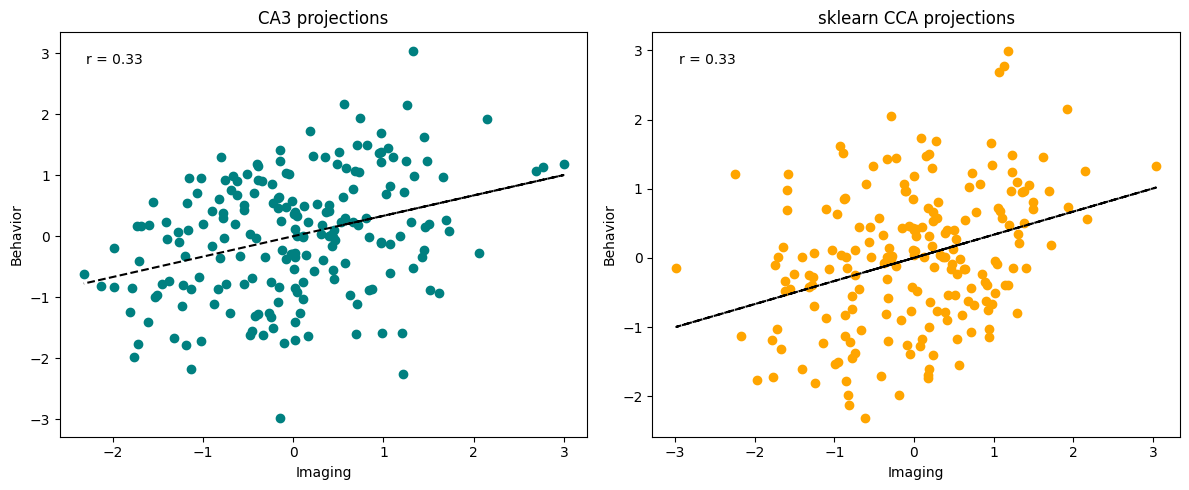

In [25]:
import matplotlib.pyplot as plt
import scipy.stats 
X1_proj_ca3 = projections[0][0]
Y1_proj_ca3 = projections[0][1]
display(scipy.stats.ttest_ind(X1_proj_ca3.flatten(), X1_proj_cca.flatten() ))
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.scatter(X1_proj_ca3, Y1_proj_ca3, c='teal')
m, b = np.polyfit(X1_proj_ca3.flatten(), Y1_proj_ca3.flatten(), 1)
plt.plot(X1_proj_ca3, m*X1_proj_ca3 + b, color='black', linestyle='--')
plt.text(0.05, 0.95, f"r = {ca3_corr:.2f}", 
         transform=plt.gca().transAxes, va='top', ha='left')
plt.title("CA3 projections")
plt.xlabel("Imaging")
plt.ylabel("Behavior")

plt.subplot(1, 2, 2)
plt.scatter(X1_proj_cca, Y1_proj_cca, c='orange', label=f"r = {sklearn_corr:.2f}")
m, b = np.polyfit(X1_proj_cca.flatten(), Y1_proj_cca.flatten(), 1)
plt.plot(X1_proj_cca, m*X1_proj_cca + b, color='black', linestyle='--')
plt.text(0.05, 0.95, f"r = {sklearn_corr:.2f}", 
         transform=plt.gca().transAxes, va='top', ha='left')
plt.title("sklearn CCA projections")
plt.xlabel("Imaging")
plt.ylabel("Behavior")
plt.tight_layout()
plt.show()